# Decomposing a time series

Seasonal decomposition is a process by which we break a time series into its **trend**, **seasonal**, and **residuals** components.

1. **Detrend**: Estimates the trend component of a time series.
2. **Seasonal**: Estimates the seasonal component of a time series.
3. What is left is the residuals (noise or other unexplained components).

## Detrend

Two popular methods for detrending are:
1. Moving average
    - moving avg is a smoothed out time series
    - shows slo change in time series (trend)
    - It's still noisy
2. Locally estimated scatterplot smoothing (LOESS) regression
    - Also known as locally weighted polynomial regression.
    - It is a non-paramteric method (does not assume / rely on a specific form or distribution for the data)
    

LOESS Algorithm
For each point in the dataset:
- LOESS fits a simple polynomial (usually linear or quadratic) to a local subset of the data — i.e., points near the target point.
- It gives higher weights to nearby points and lower weights to far-away points using a kernel (usually a tricube weight function).

This local regression is repeated across all points, and the result is a smooth curve.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data with trend + seasonality + noise
np.random.seed(42)
n_months = 5 * 12  # 5 years of monthly data
time = np.arange(n_months)

# Components
trend = 0.5 * time / 12  # yearly increasing trend
seasonality = 10 * np.sin(2 * np.pi * time / 12)  # yearly seasonality
noise = np.random.normal(scale=2, size=n_months)

# Combine to form time series
data = trend + seasonality + noise

# Create DataFrame
date_range = pd.date_range(start='2018-01-01', periods=n_months, freq='M')
df = pd.DataFrame({'date': date_range, 'value': data})
df.set_index('date', inplace=True)
df.head()


/tmp/ipykernel_25378/969134858.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2018-01-01', periods=n_months, freq='M')


,value
date,
2018-01-31,0.993428
2018-02-28,4.765138
2018-03-31,10.038964
2018-04-30,13.171060
2018-05-31,8.358614


In [2]:
df.shape

(60, 1)

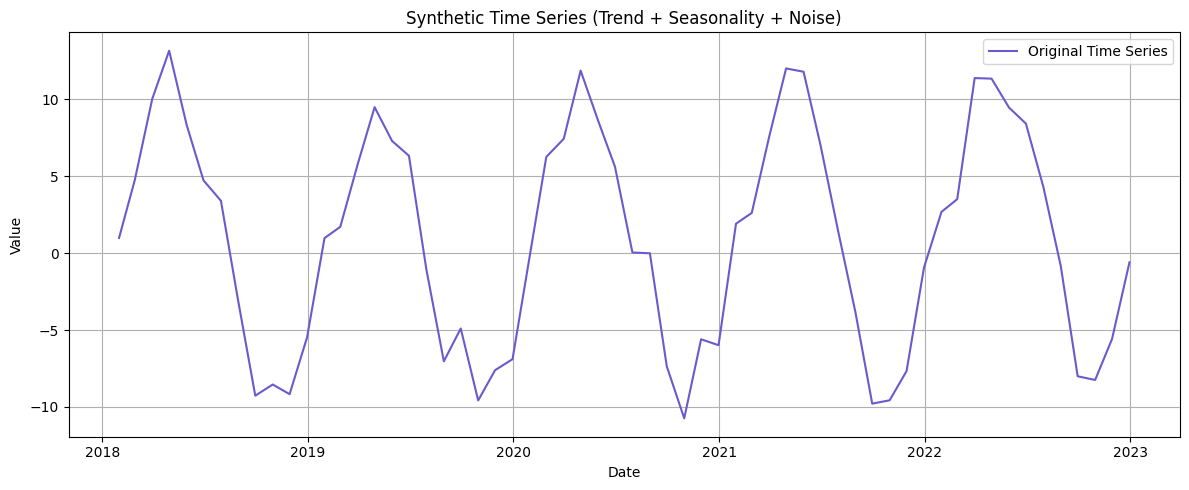

In [3]:
# Plot the raw time series
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], label='Original Time Series', color='slateblue')
plt.title('Synthetic Time Series (Trend + Seasonality + Noise)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Apply LOESS smoothing to extract trend
loess_result = lowess(df['value'], np.arange(len(df)), frac=0.2, return_sorted=False)

# Add trend to DataFrame
df['trend_loess'] = loess_result


In [5]:
df.head()

,value,trend_loess
date,,
2018-01-31,0.993428,8.096281
2018-02-28,4.765138,7.447160
2018-03-31,10.038964,6.598306
2018-04-30,13.171060,5.611313
2018-05-31,8.358614,4.553781


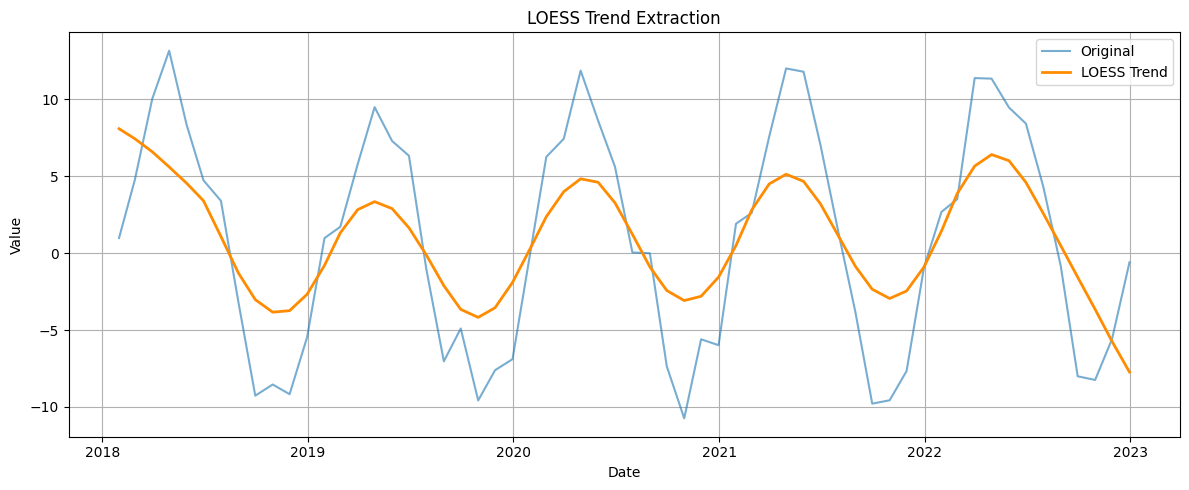

In [6]:
# Plot original vs trend
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], label='Original', alpha=0.6)
plt.plot(df.index, df['trend_loess'], label='LOESS Trend', color='darkorange', linewidth=2)
plt.title('LOESS Trend Extraction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression

# Define parameters
P = 12  # period (monthly seasonality, one cycle per year)
N_terms = 3  # number of Fourier terms (n=1 to 3)
t = np.arange(len(df))  # time index

# Create Fourier features
fourier_terms = pd.DataFrame(index=df.index)
for n in range(1, N_terms + 1):
    fourier_terms[f'sin_{n}'] = np.sin(2 * np.pi * n * t / P)
    fourier_terms[f'cos_{n}'] = np.cos(2 * np.pi * n * t / P)


In [8]:
fourier_terms.head()

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3
date,,,,,,
2018-01-31,0.000000,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00
2018-02-28,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17
2018-03-31,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00
2018-04-30,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16
2018-05-31,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00


Fourier terms (sine and cosine components) describe the periodic patterns (seasonality) in a time series. They are the building blocks that, when combined, can reconstruct complex repeating behavior in data.

In [9]:

# Fit linear model to capture seasonality
y = df['value'] - df['trend_loess']  # detrended signal (only seasonality + noise)
model = LinearRegression().fit(fourier_terms, y)
df['seasonal_fourier'] = model.predict(fourier_terms)


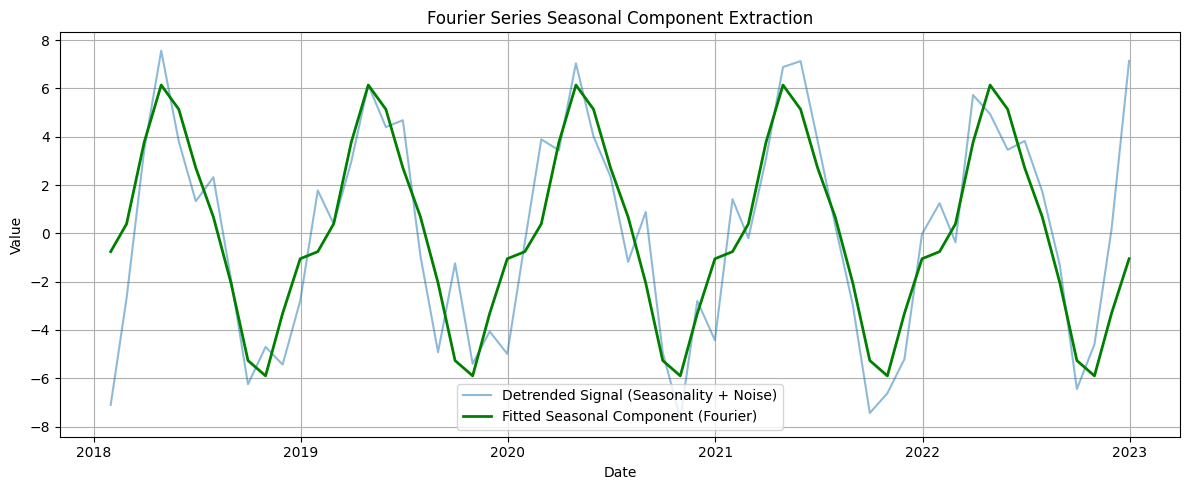

In [10]:

# Plot the seasonal component
plt.figure(figsize=(12, 5))
plt.plot(df.index, y, label='Detrended Signal (Seasonality + Noise)', alpha=0.5)
plt.plot(df.index, df['seasonal_fourier'], color='green', label='Fitted Seasonal Component (Fourier)', linewidth=2)
plt.title('Fourier Series Seasonal Component Extraction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
